<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/vector_drug_CLIPModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://huggingface.co/openai/clip-vit-large-patch14

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [ ]:
print("Image-text similarity scores:", logits_per_image)
print("Label probabilities:", probs)

Image-text similarity scores: tensor([[18.9041, 11.7159]], grad_fn=<TBackward0>)
Label probabilities: tensor([[9.9925e-01, 7.5487e-04]], grad_fn=<SoftmaxBackward0>)


In [29]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Path to your local image file
image_path = "/content/22_0.jpg"
image = Image.open(image_path)

# Prepare the inputs for the model
inputs = processor(text=["Novonorm1mg", "Novonorm2mg", "Novonorm"], images=image, return_tensors="pt", padding=True)

# Forward pass through the model
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # This is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # Take the softmax to get the label probabilities

print("Image-text similarity scores:", logits_per_image)
print("Label probabilities:", probs)

Image-text similarity scores: tensor([[26.0049, 24.9745, 19.6755]], grad_fn=<TBackward0>)
Label probabilities: tensor([[0.7360, 0.2627, 0.0013]], grad_fn=<SoftmaxBackward0>)


# image + text 2vector

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/drug/data 50 class add_augment.zip'

In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from datetime import datetime

# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Path to the main directory containing 50 subfolders
main_directory = "/content/data 50 class add_augment - Copy"

# Prepare lists to store rows for CSV
rows = []

# Start timer for the whole process
start_time = datetime.now()

# Collect images and text labels from the subfolders and convert them to vectors
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    if os.path.isdir(folder_path):
        text_label = folder_name

        # Start timer for the current folder
        folder_start_time = datetime.now()

        # Collect all images from the current folder
        image_files = [os.path.join(folder_path, image_name) for image_name in os.listdir(folder_path)]

        for image_path in image_files:
            # Open the image
            image = Image.open(image_path)

            # Prepare the inputs for the CLIP model
            inputs = processor(text=[text_label], images=image, return_tensors="pt", padding=True)

            # Move inputs to the GPU
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs)

            # Get the image and text embeddings
            image_embedding = outputs.image_embeds.squeeze().cpu().tolist()
            text_embedding = outputs.text_embeds.squeeze().cpu().tolist()

            # Create a row for the CSV
            row = [text_label, image_path] + image_embedding + text_embedding
            rows.append(row)

        # End timer for the current folder
        folder_end_time = datetime.now()
        folder_duration = folder_end_time - folder_start_time
        print(f"Converted vectors for folder: {folder_name} in {folder_duration}")

# End timer for the whole process
end_time = datetime.now()
total_duration = end_time - start_time

# Define the header for the CSV file
header = ['TextLabel', 'ImagePath'] + [f'ImageEmbed_{i}' for i in range(len(image_embedding))] + [f'TextEmbed_{i}' for i in range(len(text_embedding))]

# Write the data to a CSV file
csv_file_path = '/content/class_vectors.csv'
df = pd.DataFrame(rows, columns=header)
df.to_csv(csv_file_path, index=False)

print(f"Vectors have been successfully saved to: {csv_file_path}")
print(f"Total time for processing all folders: {total_duration}")

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the CLIP model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load the CSV file containing the vectors
csv_file_path = '/content/class_vectors.csv'
df = pd.read_csv(csv_file_path)

# Extract the text labels and embeddings from the CSV
text_labels = df['TextLabel'].tolist()
image_paths = df['ImagePath'].tolist()
image_embeddings = df[[col for col in df.columns if 'ImageEmbed_' in col]].values
text_embeddings = df[[col for col in df.columns if 'TextEmbed_' in col]].values

# Convert embeddings from lists to numpy arrays
image_embeddings = np.array(image_embeddings)
text_embeddings = np.array(text_embeddings)

# Function to compare a new image with stored vectors
def compare_image_with_stored_vectors(new_image_path):
    # Open the new image
    image = Image.open(new_image_path)

    # Prepare the inputs for the CLIP model
    inputs = processor(text=text_labels, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the image and text embeddings for the new image
    new_image_embedding = outputs.image_embeds.squeeze().cpu().numpy().reshape(1, -1)  # Ensure 2D array
    new_text_embedding = outputs.text_embeds.mean(dim=0).cpu().numpy().reshape(1, -1)  # Take the mean if needed

    # Print shapes of the new embeddings
    print(f"New image embedding shape: {new_image_embedding.shape}")
    print(f"New text embedding shape: {new_text_embedding.shape}")

    # Ensure dimensions match for cosine similarity
    if new_image_embedding.shape[1] != image_embeddings.shape[1]:
        raise ValueError("Dimension mismatch between new image embedding and stored image embeddings.")
    if new_text_embedding.shape[1] != text_embeddings.shape[1]:
        raise ValueError("Dimension mismatch between new text embedding and stored text embeddings.")

    # Compute cosine similarity between new image embedding and stored image embeddings
    image_similarities = cosine_similarity(new_image_embedding, image_embeddings)
    text_similarities = cosine_similarity(new_text_embedding, text_embeddings)

    # Combine results from both similarities
    combined_similarities = np.maximum(image_similarities[0], text_similarities[0])

    # Get top 5 indices based on combined similarities
    most_similar_combined_indices = np.argsort(-combined_similarities)

    # Get unique classes
    unique_classes = set()
    top_results = []

    # Collect top results avoiding duplicate class names
    for index in most_similar_combined_indices:
        label = text_labels[index]
        if label not in unique_classes:
            unique_classes.add(label)
            top_results.append((label, combined_similarities[index]))  # Fix index usage

        if len(top_results) >= 5:
            break

    # Print the top results
    print("\nTop 5 similar classes:")
    for label, similarity in top_results:
        print(f"{label}: {similarity:.4f}")

    # Display the new image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"New Image: {new_image_path}")
    plt.axis('off')
    plt.show()

# Test all images in a folder and show results
test_images_folder = '/content/drive/MyDrive/drug/Corp_test'  # Replace with the folder path of your test images
for image_file in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_file)
    print(f"\nProcessing image: {image_file}")
    compare_image_with_stored_vectors(image_path)

In [ ]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Path to your local image file
image_path = "/content/data 50 class add_augment - Copy/Betalol40mg/Betalol40mg_bright.jpg"

# Open the image
image = Image.open(image_path)

# Define multiple text labels for comparison
text_labels = ['Amlopine_10mg', 'Amlopine_5mg', 'Anapril_5mg', 'Betalol-10-mg', 'Betalol-40-mg',
               'Blopress-16-mg', 'Blopress-8-mg', 'Blopress-Plus-16-mg', 'Blopress-Plus-8-mg',
               'Caduet-10_10-mg', 'Caduet-5_10-mg', 'Daonil-5-mg', 'Diamicron-MR-60-mg',
               'Diovan-160-mg', 'Diovan-80-mg', 'Forxiga-10-mg', 'Galvus-50-mg', 'Galvus_Met_50_1000mg',
               'Gliclazide_80mg', 'Gliparil-2-mg', 'Glucophage-500-mg', 'Glucophage-850-mg',
               'Glucophage-XR-1000-mg', 'Glucophage-XR-750-mg', 'Glyxambi-25_5-mg', 'Janumet-50_1000-mg',
               'Januvia-100-mg', 'Jardiance-10-mg', 'Jardiance-25-mg', 'Jardiance-Duo-12_5_1000-mg',
               'Lanzaar-100-mg', 'Lercadip-20-mg', 'Madiplot-10-mg', 'Madiplot_20mg',
               'Metoprolol_Stada_100mg', 'Micardis_40mg', 'Micardis_Plus_80_12_5mg', 'Minidiab_5mg',
               'Novonorm_1mg', 'Novonorm_2mg', 'Oseni_25_15mg', 'Poli_uretic', 'Prenolol_100mg',
               'Prenolol_25mg', 'Prenolol_50mg', 'Tanzaril_50mg', 'Utmos_15mg', 'Utmos_30mg',
               'Xigduo_XR_10_1000mg', 'Zanidip_10mg']

# Prepare the inputs for the CLIP model
inputs = processor(text=text_labels, images=image, return_tensors="pt", padding=True)

# Forward pass through the model
outputs = model(**inputs)

# Get the image-text similarity scores
logits_per_image = outputs.logits_per_image

# Compute the probabilities
probs = logits_per_image.softmax(dim=1)

# Get the top 5 similarity scores and their corresponding text labels
top_probs, top_indices = probs.topk(5, dim=1)

# Convert to lists for easier manipulation
top_probs = top_probs.squeeze().tolist()
top_indices = top_indices.squeeze().tolist()

# Print the top 5 similarity scores and their corresponding text labels in descending order
print("Top 5 similarity scores and corresponding text labels:")
for i, idx in enumerate(top_indices):
    print(f"{text_labels[idx]}: {top_probs[i]:.4f}")

Top 5 similarity scores and corresponding text labels:
Betalol-40-mg: 0.7764
Betalol-10-mg: 0.1812
Prenolol_50mg: 0.0250
Prenolol_100mg: 0.0084
Prenolol_25mg: 0.0051


# image2vector

##224*224

###50cls

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

# ใช้โมเดล CLIP ของ Hugging Face ในการทำ embedding
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def image_embedding(path):
    img = Image.open(path).convert('RGB').resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ CLIP
    inputs = processor(images=img, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    avg_embedding = outputs.squeeze().detach().numpy()  # ค่า embedding ของภาพ

    curr_df = pd.DataFrame(avg_embedding).T
    return curr_df

def process_images_in_folder(folder_path, output_csv_path):
    pdEmbedded = pd.DataFrame()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        embedded = image_embedding(image_path)
        embedded['ID'] = image_file  # ใช้ชื่อไฟล์เป็น ID
        pdEmbedded = pd.concat([pdEmbedded, embedded], ignore_index=True)

    # สร้างโฟลเดอร์สำหรับ output_csv_path
    output_folder = os.path.dirname(output_csv_path)
    os.makedirs(output_folder, exist_ok=True)

    # บันทึก DataFrame ลงในไฟล์ CSV
    pdEmbedded.to_csv(output_csv_path, index=False)

# ฟังก์ชันสำหรับการวนลูปโฟลเดอร์
def process_all_folders(base_folder_path, output_base_folder):
    subfolders = [f.path for f in os.scandir(base_folder_path) if f.is_dir()]

    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        output_csv_path = os.path.join(output_base_folder, f"{subfolder_name}.csv")
        process_images_in_folder(subfolder, output_csv_path)
        print(f"Embedding data for {subfolder_name} has been saved to {output_csv_path}")

# ตัวอย่างการใช้งาน
base_folder_path = "/content/data 50 class add_augment - Copy"
output_base_folder = "/content/drug50cls_CLIPModel"
os.makedirs(output_base_folder, exist_ok=True)  # สร้างโฟลเดอร์หลักถ้ายังไม่มี

process_all_folders(base_folder_path, output_base_folder)

In [4]:
# โหลดข้อมูลเวกเตอร์224*224
# Export Data drug50cls
# Define the folder you want to zip and download
import shutil

folder_to_download = '/content/drug50cls_CLIPModel'

# Zip the folder
shutil.make_archive('/content/drive/MyDrive/drug/drug50cls_CLIPModel', 'zip', folder_to_download)

# Download the zip file
from google.colab import files
files.download('/content/drive/MyDrive/drug/drug50cls_CLIPModel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Cosine similarity

In [5]:
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# ใช้โมเดล CLIP ของ Hugging Face ในการทำ embedding
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

# ย้ายโมเดลไปยัง GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ CLIP
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        avg_embedding = outputs.squeeze().cpu().detach().numpy()  # ค่า embedding ของภาพ
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_CLIPModel'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/11_0.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

Top 5 most similar classes:
1. Class: Novonorm1mg, Similarity Score: 0.9259026699786254
2. Class: Novonorm2mg, Similarity Score: 0.9195596741540191
3. Class: Blopress8mg, Similarity Score: 0.9005363853770779
4. Class: Daonil5mg, Similarity Score: 0.9001865754719013
5. Class: Januvia100mg, Similarity Score: 0.8908871779090606


Image: image16.jpg
Top 5 most similar classes:
1. Class: Minidiab5mg, Similarity Score: 0.8702409708379876
2. Class: BlopressPlus8mg, Similarity Score: 0.8654272427888153
3. Class: Blopress8mg, Similarity Score: 0.8625866565752826
4. Class: Daonil5mg, Similarity Score: 0.8576282071635636
5. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.8470886877771219



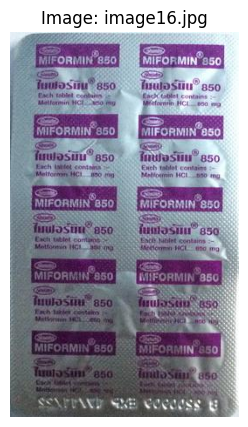

Image: image12.jpg
Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.8316965033097354
2. Class: Anapril5mg, Similarity Score: 0.8133305920744521
3. Class: Prenolol100mg, Similarity Score: 0.809916422444499
4. Class: Betalol40mg, Similarity Score: 0.8000395089656418
5. Class: GalvusMet50_1000mg, Similarity Score: 0.7936883041263119



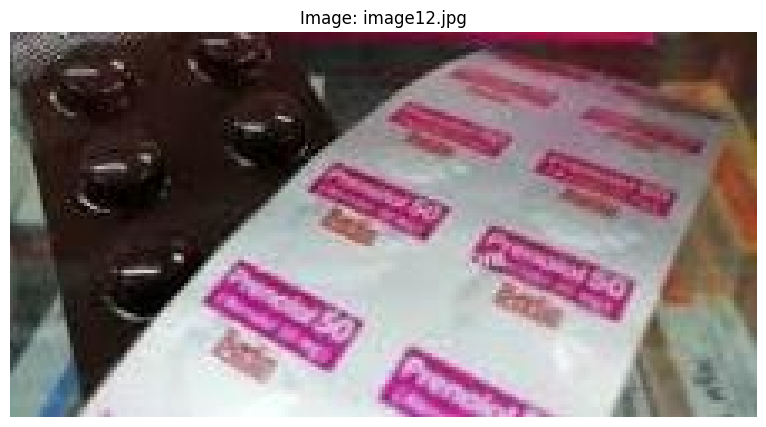

Image: image13.jpg
Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.9300442469902214
2. Class: Betalol40mg, Similarity Score: 0.9046421232530766
3. Class: Prenolol100mg, Similarity Score: 0.8803322118215376
4. Class: BlopressPlus16mg, Similarity Score: 0.8768947686362645
5. Class: Amlopine10mg, Similarity Score: 0.8743738545009346



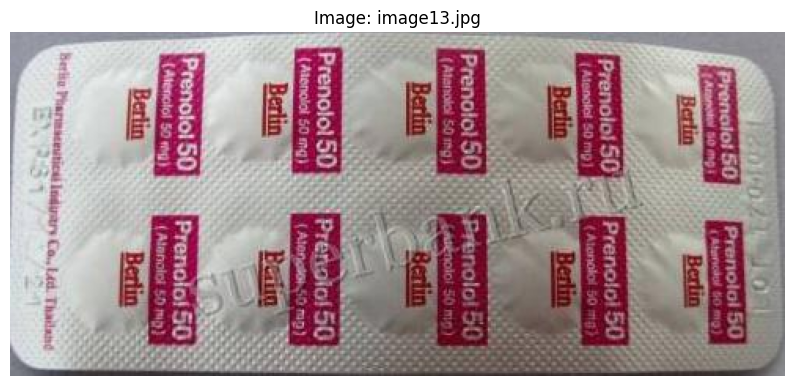

Image: image8.jpg
Top 5 most similar classes:
1. Class: Novonorm2mg, Similarity Score: 0.9036310169557392
2. Class: Forxiga10mg, Similarity Score: 0.8805750876693557
3. Class: Novonorm1mg, Similarity Score: 0.8747167147405315
4. Class: Diovan80mg, Similarity Score: 0.8734328477161006
5. Class: GalvusMet50_1000mg, Similarity Score: 0.8710132682883306



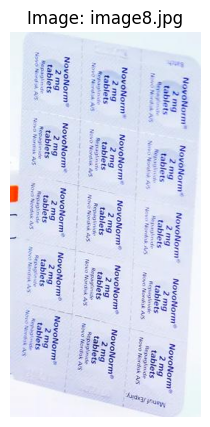

Image: image9.jpg
Top 5 most similar classes:
1. Class: Oseni25_15mg, Similarity Score: 0.7851142357030791
2. Class: Daonil5mg, Similarity Score: 0.780611594760889
3. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.7796700437962534
4. Class: Minidiab5mg, Similarity Score: 0.7757171459001265
5. Class: Prenolol50mg, Similarity Score: 0.7707325712622518



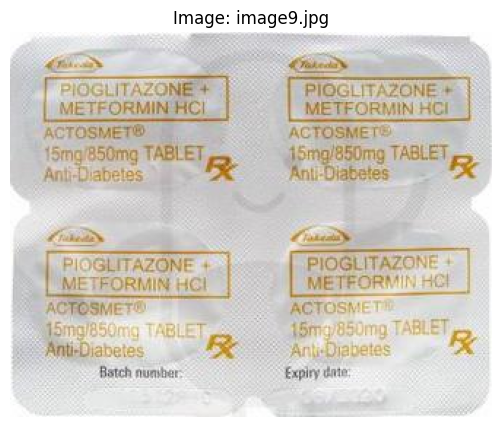

Image: image18.jpg
Top 5 most similar classes:
1. Class: Anapril5mg, Similarity Score: 0.7930911340535566
2. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.7813110016539923
3. Class: Utmos30mg, Similarity Score: 0.7736638768142001
4. Class: GlucophageXR1000mg, Similarity Score: 0.7691563054005416
5. Class: Prenolol100mg, Similarity Score: 0.7664444457483987



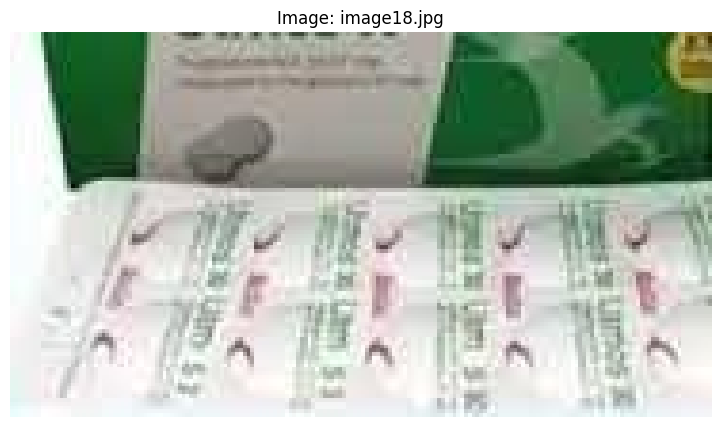

Image: image10.jpg
Top 5 most similar classes:
1. Class: Poli_uretic, Similarity Score: 0.8900970518763227
2. Class: Gliclazide80mg, Similarity Score: 0.8728868117866196
3. Class: Januvia100mg, Similarity Score: 0.871486073384533
4. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.8688447478395269
5. Class: Glucophage500mg, Similarity Score: 0.8648992724584907



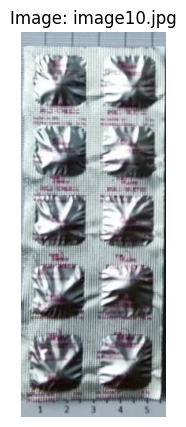

Image: image20.jpg
Top 5 most similar classes:
1. Class: XigduoXR10_1000mg, Similarity Score: 0.9050891951487608
2. Class: Diovan160mg, Similarity Score: 0.7853705767967741
3. Class: Gliclazide80mg, Similarity Score: 0.7778539541512666
4. Class: GalvusMet50_1000mg, Similarity Score: 0.775624617765561
5. Class: Minidiab5mg, Similarity Score: 0.7734915200135124



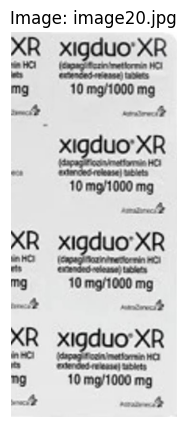

Image: image2.jpg
Top 5 most similar classes:
1. Class: Jardiance10mg, Similarity Score: 0.8572746248908323
2. Class: Poli_uretic, Similarity Score: 0.8553159430800283
3. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.8531347054410144
4. Class: Gliparil2mg, Similarity Score: 0.8496205236120123
5. Class: Diovan160mg, Similarity Score: 0.8413426179250242



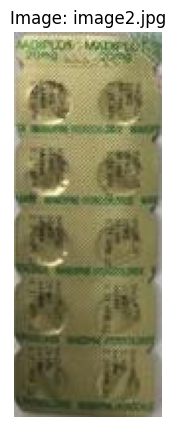

Image: image4.jpg
Top 5 most similar classes:
1. Class: Minidiab5mg, Similarity Score: 0.8455393021214698
2. Class: GlucophageXR750mg, Similarity Score: 0.7413344490785406
3. Class: Tanzaril50mg, Similarity Score: 0.7377768999451412
4. Class: Januvia100mg, Similarity Score: 0.7364716051899544
5. Class: Gliclazide80mg, Similarity Score: 0.7337838041922583



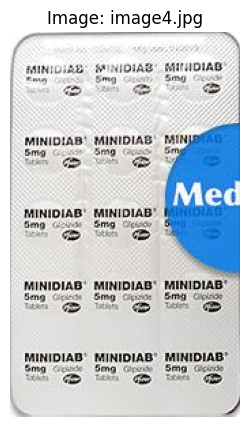

Image: image19.jpg
Top 5 most similar classes:
1. Class: Utmos30mg, Similarity Score: 0.8748443201270791
2. Class: Utmos15mg, Similarity Score: 0.8333109088995685
3. Class: Anapril5mg, Similarity Score: 0.7234553830542063
4. Class: DiamicronMR60mg, Similarity Score: 0.6972033250525206
5. Class: GalvusMet50_1000mg, Similarity Score: 0.6835004512395155



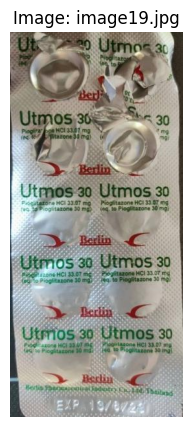

Image: image11.jpg
Top 5 most similar classes:
1. Class: Prenolol25mg, Similarity Score: 0.884718133656012
2. Class: Betalol40mg, Similarity Score: 0.8348974364132256
3. Class: Prenolol50mg, Similarity Score: 0.8140621690831241
4. Class: Betalol10mg, Similarity Score: 0.7987340695179412
5. Class: Amlopine5mg, Similarity Score: 0.7943868423640286



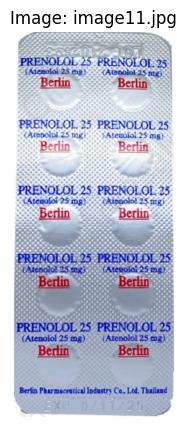

Image: image6.jpg
Top 5 most similar classes:
1. Class: Novonorm2mg, Similarity Score: 0.851053617162582
2. Class: Forxiga10mg, Similarity Score: 0.8139269619972266
3. Class: Galvus50mg, Similarity Score: 0.8136362895445024
4. Class: GalvusMet50_1000mg, Similarity Score: 0.8124613259462927
5. Class: Amlopine5mg, Similarity Score: 0.8101684358716564



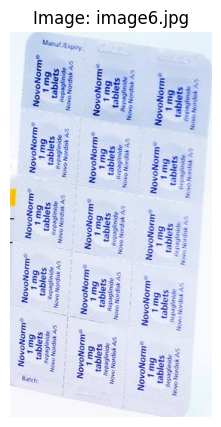

Image: image1.jpg
Top 5 most similar classes:
1. Class: Tanzaril50mg, Similarity Score: 0.8279777224355473
2. Class: Gliclazide80mg, Similarity Score: 0.8253640109581039
3. Class: Prenolol25mg, Similarity Score: 0.8229079951677719
4. Class: Lanzaar100mg, Similarity Score: 0.8216736369142971
5. Class: Januvia100mg, Similarity Score: 0.816689919084414



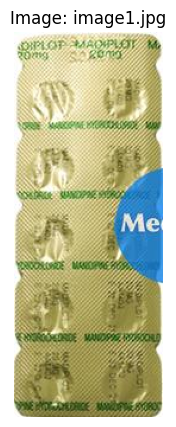

Image: image14.jpg
Top 5 most similar classes:
1. Class: Prenolol50mg, Similarity Score: 0.889662617792204
2. Class: Prenolol100mg, Similarity Score: 0.8442699971703354
3. Class: Minidiab5mg, Similarity Score: 0.8434231003144104
4. Class: Blopress8mg, Similarity Score: 0.8348439396380253
5. Class: Betalol10mg, Similarity Score: 0.8343227276989649



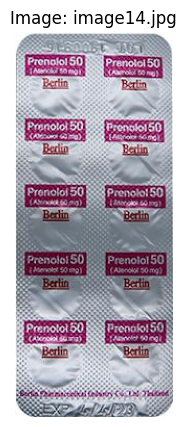

Image: image17.jpg
Top 5 most similar classes:
1. Class: Utmos30mg, Similarity Score: 0.8888135977256008
2. Class: Utmos15mg, Similarity Score: 0.8162029901953213
3. Class: Amlopine5mg, Similarity Score: 0.7563684739109595
4. Class: Prenolol25mg, Similarity Score: 0.7500649303696907
5. Class: BlopressPlus16mg, Similarity Score: 0.7488858897998207



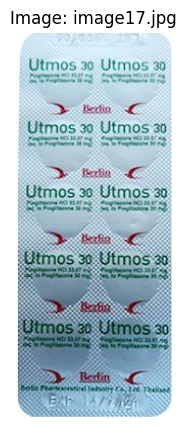

Image: image15.jpg
Top 5 most similar classes:
1. Class: Minidiab5mg, Similarity Score: 0.883329864093654
2. Class: Janumet50_1000mg, Similarity Score: 0.8818259232345237
3. Class: Blopress8mg, Similarity Score: 0.8766648290852035
4. Class: Daonil5mg, Similarity Score: 0.8730143357005393
5. Class: BlopressPlus16mg, Similarity Score: 0.8709199190142374



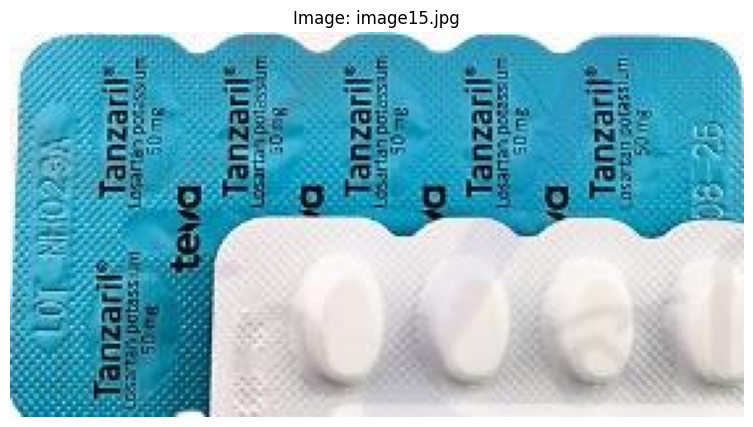

Image: image21.jpg
Top 5 most similar classes:
1. Class: Gliclazide80mg, Similarity Score: 0.8547419447033702
2. Class: Diovan80mg, Similarity Score: 0.8474779791368143
3. Class: Lercadip20mg, Similarity Score: 0.8466269269701101
4. Class: Tanzaril50mg, Similarity Score: 0.8435280223789047
5. Class: Blopress8mg, Similarity Score: 0.8418438165677707



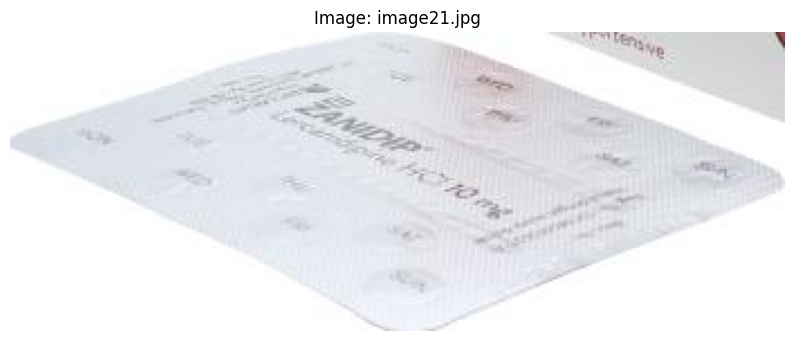

Image: image5.jpg
Top 5 most similar classes:
1. Class: MetoprololStada100mg, Similarity Score: 0.9090739179871288
2. Class: Janumet50_1000mg, Similarity Score: 0.9016173157860858
3. Class: GalvusMet50_1000mg, Similarity Score: 0.8969008328724508
4. Class: GlucophageXR1000mg, Similarity Score: 0.8967387361795103
5. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.8941091838902209



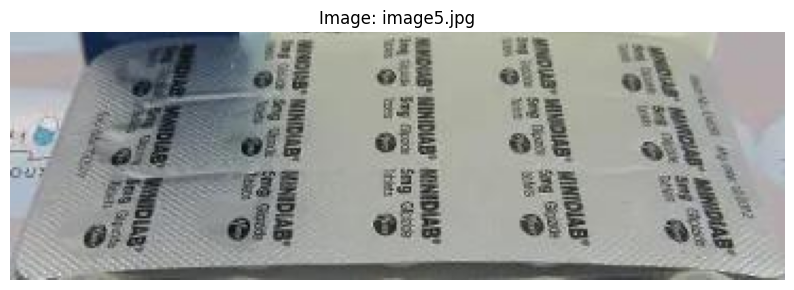

Image: image7.jpg
Top 5 most similar classes:
1. Class: Blopress8mg, Similarity Score: 0.890471712685779
2. Class: Novonorm2mg, Similarity Score: 0.8881553454474274
3. Class: BlopressPlus8mg, Similarity Score: 0.885196865014731
4. Class: JardianceDuo12.5_1000mg, Similarity Score: 0.883171425990647
5. Class: Daonil5mg, Similarity Score: 0.8793540538912669



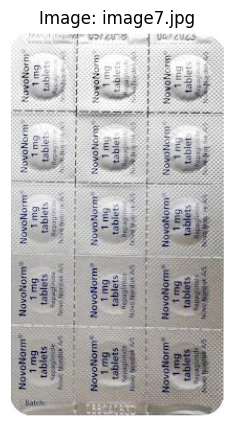

In [7]:
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import matplotlib.pyplot as plt

# ใช้โมเดล CLIP ของ Hugging Face ในการทำ embedding
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

# ย้ายโมเดลไปยัง GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((224, 224))  # ปรับขนาดภาพให้เข้ากับ CLIP
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        avg_embedding = outputs.squeeze().cpu().detach().numpy()  # ค่า embedding ของภาพ
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

def process_images_in_folder(folder_path, all_embeddings):
    results = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        similar_classes = find_most_similar_classes(image_path, all_embeddings)
        results.append({'Image': image_path, 'Top 5 Similar Classes': similar_classes})

    return results

def display_results(results):
    for result in results:
        # แสดงภาพ
        img = Image.open(result['Image'])
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 1, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {os.path.basename(result['Image'])}")

        # แสดงผลลัพธ์
        print(f"Image: {os.path.basename(result['Image'])}")
        print("Top 5 most similar classes:")
        for rank, (class_name, similarity_score) in enumerate(result['Top 5 Similar Classes'], start=1):
            print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")
        print()
        plt.show()

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_CLIPModel'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# โฟลเดอร์ที่มีภาพที่ต้องการทดสอบ
test_images_folder = '/content/drive/MyDrive/drug/Corp_test'

# ประมวลผลภาพทั้งหมดในโฟลเดอร์
results = process_images_in_folder(test_images_folder, all_embeddings)

# แสดงผลลัพธ์
display_results(results)

##640*640

###50cls

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

# ใช้โมเดล CLIP ของ Hugging Face ในการทำ embedding
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def image_embedding(path):
    img = Image.open(path).convert('RGB').resize((640, 640))  # ปรับขนาดภาพให้เข้ากับ CLIP
    inputs = processor(images=img, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    avg_embedding = outputs.squeeze().detach().numpy()  # ค่า embedding ของภาพ

    curr_df = pd.DataFrame(avg_embedding).T
    return curr_df

def process_images_in_folder(folder_path, output_csv_path):
    pdEmbedded = pd.DataFrame()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        embedded = image_embedding(image_path)
        embedded['ID'] = image_file  # ใช้ชื่อไฟล์เป็น ID
        pdEmbedded = pd.concat([pdEmbedded, embedded], ignore_index=True)

    # สร้างโฟลเดอร์สำหรับ output_csv_path
    output_folder = os.path.dirname(output_csv_path)
    os.makedirs(output_folder, exist_ok=True)

    # บันทึก DataFrame ลงในไฟล์ CSV
    pdEmbedded.to_csv(output_csv_path, index=False)

# ฟังก์ชันสำหรับการวนลูปโฟลเดอร์
def process_all_folders(base_folder_path, output_base_folder):
    subfolders = [f.path for f in os.scandir(base_folder_path) if f.is_dir()]

    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        output_csv_path = os.path.join(output_base_folder, f"{subfolder_name}.csv")
        process_images_in_folder(subfolder, output_csv_path)
        print(f"Embedding data for {subfolder_name} has been saved to {output_csv_path}")

# ตัวอย่างการใช้งาน
base_folder_path = "/content/data 50 class add_augment - Copy"
output_base_folder = "/content/drug50cls_CLIPModel_640"
os.makedirs(output_base_folder, exist_ok=True)  # สร้างโฟลเดอร์หลักถ้ายังไม่มี

process_all_folders(base_folder_path, output_base_folder)

In [9]:
# โหลดข้อมูลเวกเตอร์640*640
# Export Data drug50cls
# Define the folder you want to zip and download
import shutil

folder_to_download = '/content/drug50cls_CLIPModel_640'

# Zip the folder
shutil.make_archive('/content/drive/MyDrive/drug/drug50cls_CLIPModel_640', 'zip', folder_to_download)

# Download the zip file
from google.colab import files
files.download('/content/drive/MyDrive/drug/drug50cls_CLIPModel_640.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Cosine similarity

In [11]:
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# ใช้โมเดล CLIP ของ Hugging Face ในการทำ embedding
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

# ย้ายโมเดลไปยัง GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def image_embedding(path):
    try:
        img = Image.open(path).convert('RGB').resize((640, 640))  # ปรับขนาดภาพให้เข้ากับ CLIP
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        avg_embedding = outputs.squeeze().cpu().detach().numpy()  # ค่า embedding ของภาพ
        curr_df = pd.DataFrame(avg_embedding).T
        return curr_df
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return pd.DataFrame()

def load_embeddings_from_csv(csv_folder):
    all_embeddings = {}
    for csv_file in os.listdir(csv_folder):
        if csv_file.endswith('.csv'):
            class_name = os.path.splitext(csv_file)[0]  # ใช้ชื่อไฟล์ CSV เป็นชื่อคลาส
            csv_path = os.path.join(csv_folder, csv_file)
            df = pd.read_csv(csv_path)
            # ดรอปคอลัมน์ ID และเก็บเฉพาะเวกเตอร์ของคลาส
            embeddings_no_id = df.drop(['ID'], axis=1)
            all_embeddings[class_name] = embeddings_no_id
    return all_embeddings

def find_most_similar_classes(new_image_path, all_embeddings):
    new_embedding = image_embedding(new_image_path)
    similarity_scores = {}

    for class_name, embeddings_df in all_embeddings.items():
        # คำนวณค่า similarity ระหว่าง embedding ของรูปภาพใหม่กับ embeddings ของคลาส
        similarity_score = cosine_similarity(new_embedding, embeddings_df)
        max_similarity_score = similarity_score.max()  # หา similarity ที่สูงที่สุดในคลาส
        similarity_scores[class_name] = max_similarity_score

    sorted_similarity = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    top_5_similar_classes = sorted_similarity[:5]

    return top_5_similar_classes

# โหลด embedding จากโฟลเดอร์ที่เก็บไฟล์ CSV
csv_folder_path = '/content/drug50cls_CLIPModel_640'
all_embeddings = load_embeddings_from_csv(csv_folder_path)

# รูปภาพที่ต้องการทดสอบ
new_image_path = '/content/11_0.jpg'

# ค้นหาคลาสที่มีความคล้ายกันที่สุด 5 อันดับ
similar_classes = find_most_similar_classes(new_image_path, all_embeddings)

# แสดงผลลัพธ์
print("Top 5 most similar classes:")
for rank, (class_name, similarity_score) in enumerate(similar_classes, start=1):
    print(f"{rank}. Class: {class_name}, Similarity Score: {similarity_score}")

Top 5 most similar classes:
1. Class: Novonorm1mg, Similarity Score: 0.9256031560681242
2. Class: Novonorm2mg, Similarity Score: 0.9175729119575181
3. Class: Blopress8mg, Similarity Score: 0.9035452809524182
4. Class: Daonil5mg, Similarity Score: 0.8999247377982782
5. Class: Januvia100mg, Similarity Score: 0.8927445084949714
